同一模型、同一初始化，对比 SGD+Momentum vs Adam
超参
批大小 batch_size = 128
轮数 max_epochs = 20
学习率
SGD：lr=0.1, momentum=0.9
Adam：lr=1e-3

== SGD ==
Epoch 01  train_loss=0.3050  val_loss=0.1600  val_acc=0.9522
Epoch 02  train_loss=0.1122  val_loss=0.1150  val_acc=0.9653
Epoch 03  train_loss=0.0739  val_loss=0.1027  val_acc=0.9679
Epoch 04  train_loss=0.0559  val_loss=0.0861  val_acc=0.9737
Epoch 05  train_loss=0.0413  val_loss=0.0805  val_acc=0.9755
Epoch 06  train_loss=0.0299  val_loss=0.0827  val_acc=0.9760
Epoch 07  train_loss=0.0232  val_loss=0.0865  val_acc=0.9749
Epoch 08  train_loss=0.0187  val_loss=0.0872  val_acc=0.9748
Epoch 09  train_loss=0.0139  val_loss=0.0777  val_acc=0.9776
Epoch 10  train_loss=0.0101  val_loss=0.0785  val_acc=0.9788
Epoch 11  train_loss=0.0074  val_loss=0.0782  val_acc=0.9782
Epoch 12  train_loss=0.0051  val_loss=0.0816  val_acc=0.9783
Epoch 13  train_loss=0.0036  val_loss=0.0803  val_acc=0.9789
Epoch 14  train_loss=0.0026  val_loss=0.0790  val_acc=0.9794
Epoch 15  train_loss=0.0021  val_loss=0.0807  val_acc=0.9793
Epoch 16  train_loss=0.0018  val_loss=0.0805  val_acc=0.9794
Epoch 17  trai

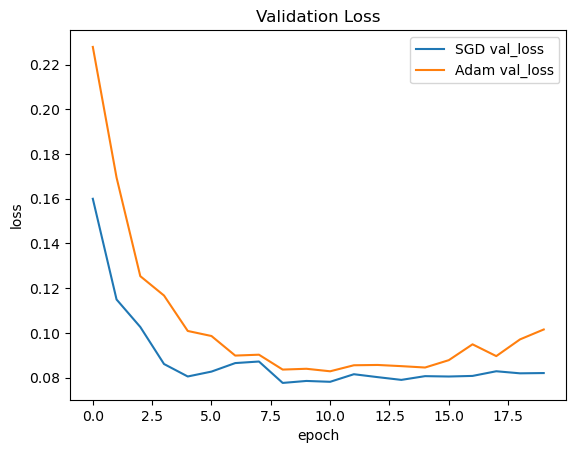

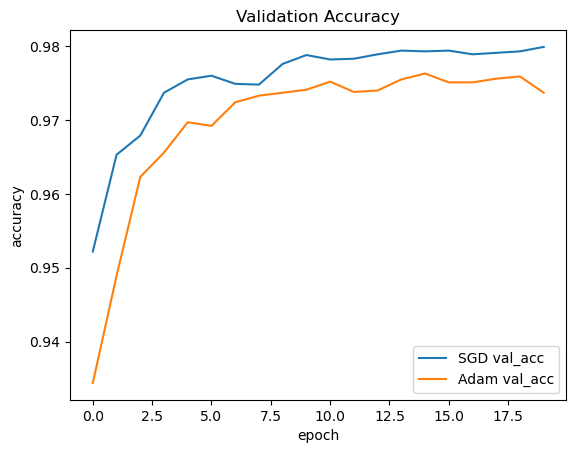

In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import copy, random, matplotlib.pyplot as plt

# reproducibility
torch.manual_seed(42); random.seed(42)

# 1) Data
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 28*28 -> 784
])
train_full = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
test = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)
n_val = 10000
train, val = random_split(train_full, [len(train_full)-n_val, n_val])
train_loader = DataLoader(train, batch_size=128, shuffle=True)
val_loader   = DataLoader(val,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test,  batch_size=256, shuffle=False)

# 2) Model
class MLP(nn.Module):
    def __init__(self, in_dim=28*28, hidden=256, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def train_eval(model, optimizer, max_epochs=20, device="cpu"):
    model.to(device)
    logs = {"train_loss": [], "val_loss": [], "val_acc": []}
    for epoch in range(1, max_epochs+1):
        # ---- train ----
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()
            optimizer.step()
            running += loss.item() * xb.size(0)
        train_loss = running / len(train_loader.dataset)

        # ---- val ----
        model.eval()
        vl, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = F.cross_entropy(logits, yb)
                vl += loss.item() * xb.size(0)
                pred = logits.argmax(1)
                correct += (pred==yb).sum().item()
                total += yb.size(0)
        val_loss = vl / len(val_loader.dataset)
        val_acc  = correct / total

        logs["train_loss"].append(train_loss)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"Epoch {epoch:02d}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")
    return logs

# same init for fairness
base = MLP()
sgd_model  = copy.deepcopy(base)
adam_model = copy.deepcopy(base)

opt_sgd  = torch.optim.SGD(sgd_model.parameters(), lr=0.1, momentum=0.9)
opt_adam = torch.optim.Adam(adam_model.parameters(), lr=1e-3)

print("== SGD ==")
logs_sgd  = train_eval(sgd_model, opt_sgd)
print("== Adam ==")
logs_adam = train_eval(adam_model, opt_adam)

# 3) Plot
plt.figure()
plt.plot(logs_sgd["val_loss"], label="SGD val_loss")
plt.plot(logs_adam["val_loss"], label="Adam val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Validation Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(logs_sgd["val_acc"], label="SGD val_acc")
plt.plot(logs_adam["val_acc"], label="Adam val_acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Validation Accuracy"); plt.legend(); plt.show()


Adam：前期快 → 适合快速原型/调试；

SGD：后期稳 → 最终准确率更高，泛化更好。

添加早停点

Step 1: 定义一个 EarlyStopping 类

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, mode="min", delta=0.0):
        """
        patience: 连续多少次没有改进就停
        mode: "min" → 监控 val_loss, "max" → 监控 val_acc
        delta: 改进阈值（小于这个幅度不算改进）
        """
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_state = None
        self.stop_epoch = 0

    def __call__(self, epoch, score, model):
        if self.mode == "min":
            score = -score   # loss 越小越好 → 转换成越大越好
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            self.counter = 0
            self.stop_epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


Step 2: 修改训练循环

在 train_eval 里加上 early stopping：

In [12]:
def train_eval(model, optimizer, max_epochs=50, device="cpu", patience=5):
    model.to(device)
    logs = {"train_loss": [], "val_loss": [], "val_acc": []}
    early_stopping = EarlyStopping(patience=patience, mode="min")  # 监控 val_loss
    
    for epoch in range(1, max_epochs+1):
        # ---- train ----
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()
            optimizer.step()
            running += loss.item() * xb.size(0)
        train_loss = running / len(train_loader.dataset)

        # ---- val ----
        model.eval()
        vl, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = F.cross_entropy(logits, yb)
                vl += loss.item() * xb.size(0)
                pred = logits.argmax(1)
                correct += (pred==yb).sum().item()
                total += yb.size(0)
        val_loss = vl / len(val_loader.dataset)
        val_acc  = correct / total

        logs["train_loss"].append(train_loss)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"Epoch {epoch:02d}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

        # ---- early stopping ----
        if early_stopping(epoch, val_loss, model):
            print(f"Early stopping triggered at epoch {epoch}")
            break
    
    # 恢复最佳参数
    model.load_state_dict(early_stopping.best_state)
    logs["stop_epoch"] = early_stopping.stop_epoch
    return logs


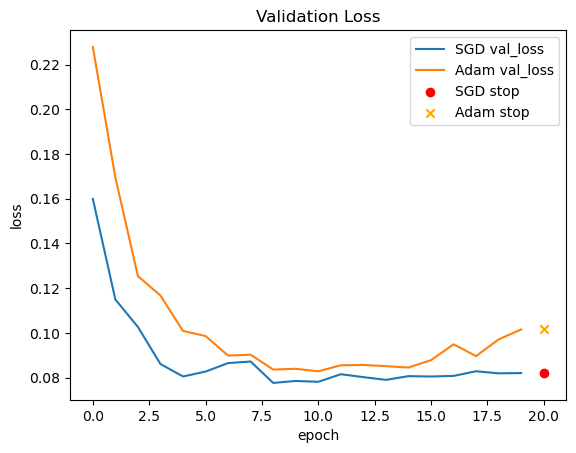

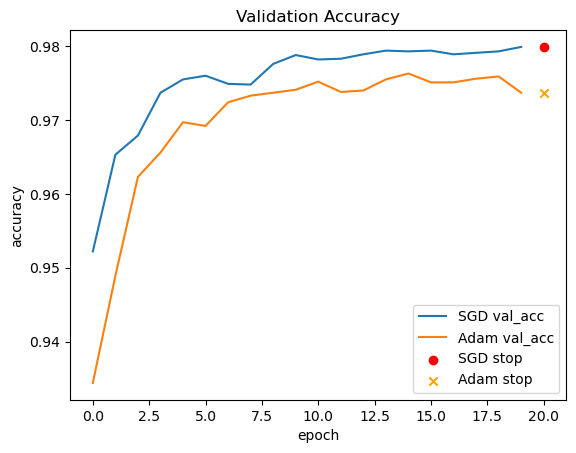

In [13]:
stop_epoch_sgd  = logs_sgd.get("stop_epoch", len(logs_sgd["val_loss"]))
stop_epoch_adam = logs_adam.get("stop_epoch", len(logs_adam["val_loss"]))

plt.figure()
plt.plot(logs_sgd["val_loss"], label="SGD val_loss")
plt.plot(logs_adam["val_loss"], label="Adam val_loss")
plt.scatter(stop_epoch_sgd, logs_sgd["val_loss"][stop_epoch_sgd-1],
            color="red", marker="o", label="SGD stop")
plt.scatter(stop_epoch_adam, logs_adam["val_loss"][stop_epoch_adam-1],
            color="orange", marker="x", label="Adam stop")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Validation Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(logs_sgd["val_acc"], label="SGD val_acc")
plt.plot(logs_adam["val_acc"], label="Adam val_acc")
plt.scatter(stop_epoch_sgd, logs_sgd["val_acc"][stop_epoch_sgd-1],
            color="red", marker="o", label="SGD stop")
plt.scatter(stop_epoch_adam, logs_adam["val_acc"][stop_epoch_adam-1],
            color="orange", marker="x", label="Adam stop")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Validation Accuracy"); plt.legend(); plt.show()


Adam：适合快速原型和早期收敛，前期冲得快。

SGD：虽然慢一些，但最终表现更好，泛化更强。

早停：在 Adam 上能有效防止过拟合，在 SGD 上差别不大。